<a href="https://colab.research.google.com/github/rgrion/mlarrozprevisao/blob/main/Experimentos_Preliminares/Treinamento_Rice_South_America_2009_a_2018_5anos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Lista de anos e dicionário para armazenar
anos = list(range(2009, 2024))
dados_por_ano = {}

for ano in anos:
    df = pd.read_csv(f'/content/Rice_{ano}.csv')
    df = df[['Area', 'Year', 'Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']].dropna()
    df = df[df['Area'] != 'South America']  # Remover o total agregado
    dados_por_ano[ano] = df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

resultados = []

# Dataset de treino
df_treino = pd.concat([
    dados_por_ano[2009], dados_por_ano[2010], dados_por_ano[2011], dados_por_ano[2012], dados_por_ano[2013],
    dados_por_ano[2014], dados_por_ano[2015], dados_por_ano[2016], dados_por_ano[2017], dados_por_ano[2018]
])
paises = df_treino['Area'].unique()

# Loop de previsão
for ano in range(2019, 2024):
    df_real = dados_por_ano[ano]

    for pais in paises:
        try:
            df_pais_treino = df_treino[df_treino['Area'] == pais]
            df_pais_real = df_real[df_real['Area'] == pais]

            if len(df_pais_treino) < 2 or df_pais_real.empty:
                continue

            # Dados de treino e predição
            X_train = df_pais_treino[['Year', 'Area harvested (ha)']]
            y_train = df_pais_treino['Production (t)']

            area_pred = df_pais_real['Area harvested (ha)'].values[0]
            X_pred = pd.DataFrame({'Year': [ano], 'Area harvested (ha)': [area_pred]})

            # Treinamento dos modelos
            lr = LinearRegression().fit(X_train, y_train)
            xgb = XGBRegressor(objective='reg:squarederror', n_estimators=50).fit(X_train, y_train)

            # Normalização para SVR
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_pred_scaled = scaler.transform(X_pred)

            svr = SVR(kernel='rbf', C=100, gamma=0.1).fit(X_train_scaled, y_train)

            # Previsões
            pred_lr = lr.predict(X_pred)[0]
            pred_xgb = xgb.predict(X_pred)[0]
            pred_svr = svr.predict(X_pred_scaled)[0]

            prod_real = df_pais_real['Production (t)'].values[0]

            resultados.append({
                'Area': pais,
                'Ano_Previsto': ano,
                'Production_Real': prod_real,
                'Prod_LR': pred_lr,
                'Prod_XGB': pred_xgb,
                'Prod_SVR': pred_svr
            })

        except Exception as e:
            print(f'Erro com país {pais} no ano {ano}: {e}')

In [ ]:
# Converter a lista em DataFrame
df_resultado = pd.DataFrame(resultados)

# Calcular erros absolutos e percentuais para cada modelo
for modelo in ['LR', 'XGB', 'SVR']:
    df_resultado[f'Erro_Abs_Prod_{modelo}'] = abs(df_resultado[f'Prod_{modelo}'] - df_resultado['Production_Real'])
    df_resultado[f'Erro_%_Prod_{modelo}'] = 100 * df_resultado[f'Erro_Abs_Prod_{modelo}'] / df_resultado['Production_Real']

# Definir formato com duas casas decimais
pd.set_option('display.float_format', '{:,.2f}'.format)

# Exibir tabela ordenada por país e ano
display(df_resultado[['Area', 'Ano_Previsto',
                      'Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR',
                      'Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']]
        .sort_values(by=['Area', 'Ano_Previsto'])
        .round(2))

,Area,Ano_Previsto,Production_Real,Prod_LR,Prod_XGB,Prod_SVR,Erro_%_Prod_LR,Erro_%_Prod_XGB,Erro_%_Prod_SVR
0,Argentina,2019,"1,189,866.00","1,242,513.78","1,367,969.88","1,481,356.31",4.42,14.97,24.50
12,Argentina,2020,"1,222,910.00","1,263,232.83","1,367,969.88","1,481,364.50",3.30,11.86,21.13
24,Argentina,2021,"1,453,187.00","1,370,694.47","1,367,969.88","1,481,396.81",5.68,5.86,1.94
36,Argentina,2022,"1,222,426.00","1,282,366.09","1,367,969.88","1,481,385.44",4.90,11.91,21.18
48,Argentina,2023,"1,163,209.00","1,199,887.61","1,367,969.88","1,481,402.54",3.15,17.60,27.35
1,Bolivia (Plurinational State of),2019,"600,044.00","515,743.37","515,305.84","458,817.41",14.05,14.12,23.54
13,Bolivia (Plurinational State of),2020,"487,427.00","524,497.74","515,305.84","458,868.66",7.61,5.72,5.86
25,Bolivia (Plurinational State of),2021,"550,181.52","533,947.12","515,305.84","458,859.46",2.95,6.34,16.60
37,Bolivia (Plurinational State of),2022,"608,680.66","544,586.43","515,305.84","458,764.06",10.53,15.34,24.63
49,Bolivia (Plurinational State of),2023,"698,543.58","554,184.58","515,305.84","458,751.07",20.67,26.23,34.33


In [ ]:
#3(b)

atributos_numericos = ['Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']

estatisticas = df_treino[atributos_numericos].agg(['mean', 'min', 'max']).transpose().reset_index()
estatisticas.columns = ['Atributo', 'Média', 'Mínimo', 'Máximo']

estatisticas['Possível Outlier'] = (
    (estatisticas['Mínimo'] < estatisticas['Média'] * 0.5) |
    (estatisticas['Máximo'] > estatisticas['Média'] * 1.5)
)

print("Estatísticas descritivas dos atributos:")
print(estatisticas.round(2))

Estatísticas descritivas dos atributos:
              Atributo        Média    Mínimo        Máximo  Possível Outlier
0       Production (t) 2,045,192.62 94,672.50 13,476,994.00              True
1  Area harvested (ha)   394,613.19 20,937.00  2,872,036.00              True
2        Yield (kg/ha)     5,302.70  2,200.10      8,687.60              True


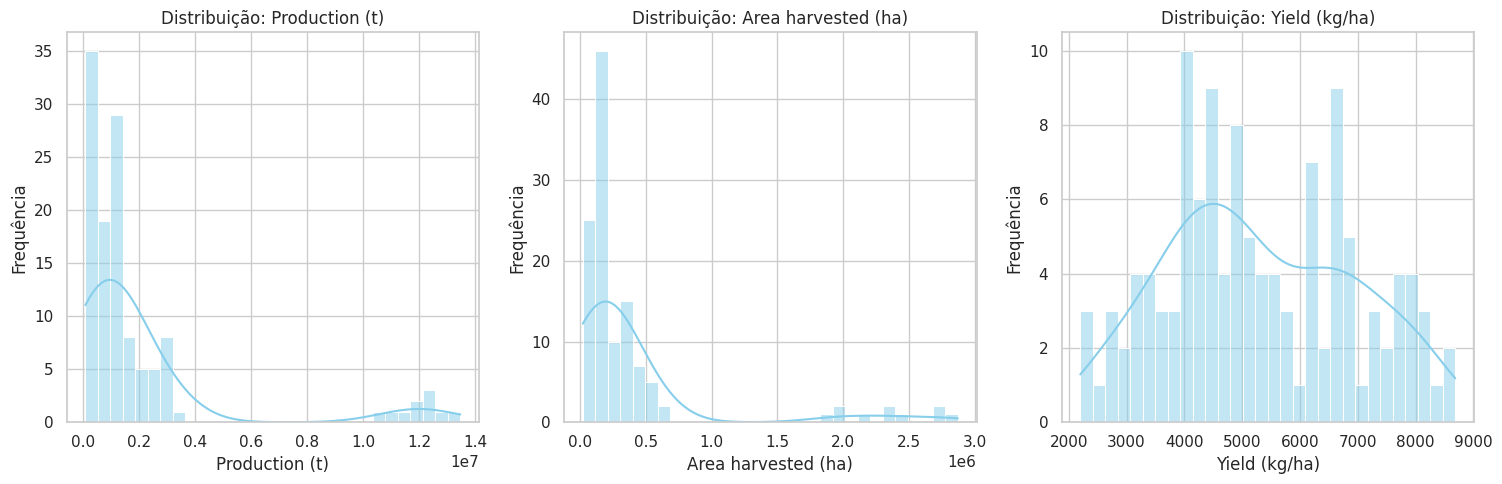

In [ ]:
#3(c)

import matplotlib.pyplot as plt
import seaborn as sns

atributos_numericos = ['Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']

# Configuração do estilo
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

for i, atributo in enumerate(atributos_numericos):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_treino[atributo], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribuição: {atributo}')
    plt.xlabel(atributo)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [ ]:
#3(d)

# Verificar dados ausentes por coluna
faltantes = df_treino.isnull().sum()

print("Valores faltantes por atributo:")
print(faltantes)

# Exibir apenas colunas com valores ausentes, se houver
faltantes_existem = faltantes[faltantes > 0]

if not faltantes_existem.empty:
    print("\nAtributos com dados faltantes detectados. Removendo linhas com valores ausentes...")
    df_treino = df_treino.dropna()
    print("Dados faltantes removidos. Novo shape do dataframe:", df_treino.shape)
else:
    print("\nNenhum dado faltante encontrado. Nenhuma modificação necessária.")

Valores faltantes por atributo:
Area                   0
Year                   0
Production (t)         0
Area harvested (ha)    0
Yield (kg/ha)          0
dtype: int64

Nenhum dado faltante encontrado. Nenhuma modificação necessária.


In [ ]:
#3(e)

# Verificar tipos de dados
print("Tipos de dados no df_treino:")
print(df_treino.dtypes)

# Verificar se há colunas categóricas
colunas_categoricas = df_treino.select_dtypes(include='object').columns
print("\nAtributos categóricos detectados:")
print(colunas_categoricas.tolist())

Tipos de dados no df_treino:
Area                    object
Year                     int64
Production (t)         float64
Area harvested (ha)    float64
Yield (kg/ha)          float64
dtype: object

Atributos categóricos detectados:
['Area']


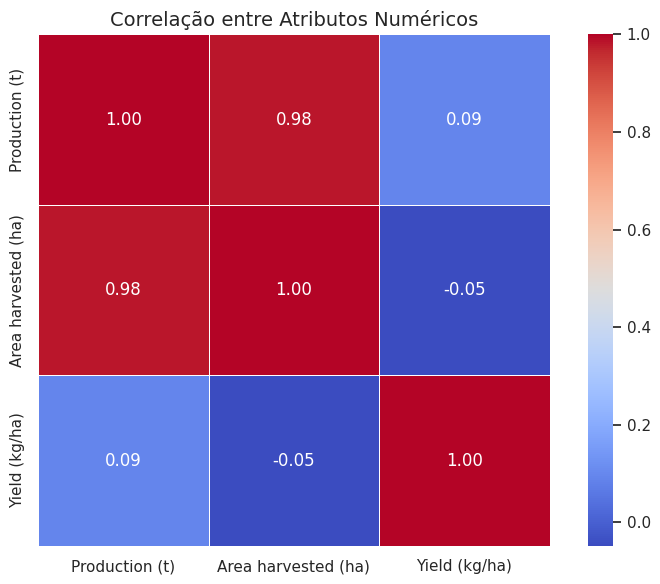

In [ ]:
#3(f)
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar apenas os atributos numéricos
atributos_numericos = ['Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']

# Calcular a matriz de correlação
correlacoes = df_treino[atributos_numericos].corr()

# Plot do heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlação entre Atributos Numéricos', fontsize=14)
plt.tight_layout()
plt.show()

Production (t): 10 outliers detectados
Area harvested (ha): 10 outliers detectados
Yield (kg/ha): 0 outliers detectados


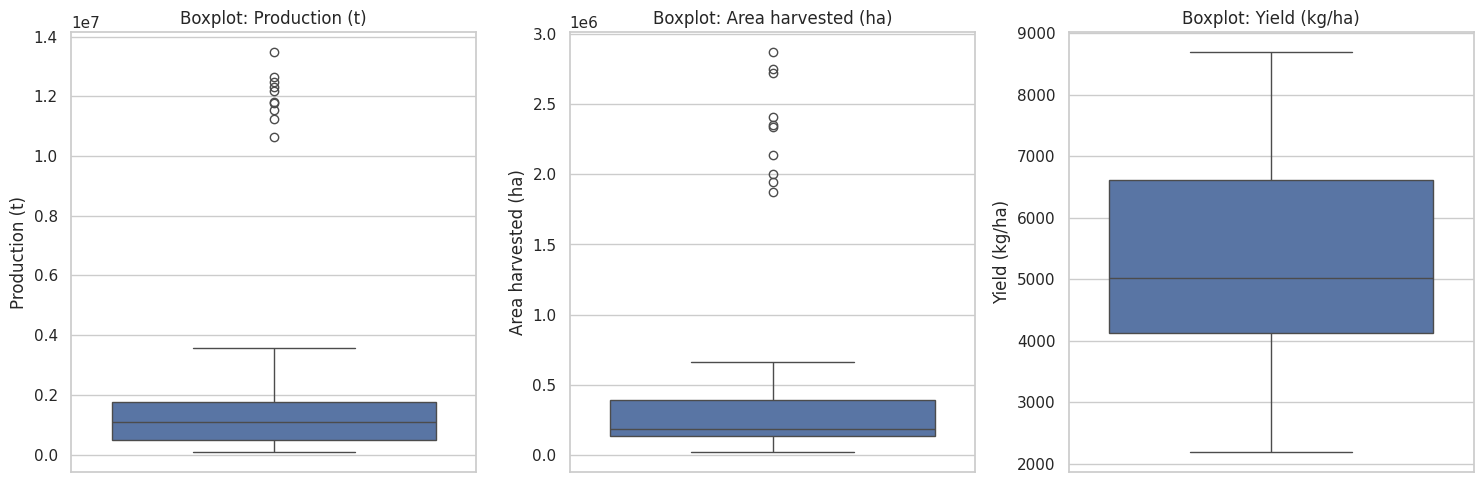

In [ ]:
#3(g)

import numpy as np

atributos_numericos = ['Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']

outliers_detectados = {}

for col in atributos_numericos:
    Q1 = df_treino[col].quantile(0.25)
    Q3 = df_treino[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = df_treino[(df_treino[col] < limite_inferior) | (df_treino[col] > limite_superior)]
    outliers_detectados[col] = outliers.shape[0]

    print(f"{col}: {outliers.shape[0]} outliers detectados")

# visualizar boxplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
for i, col in enumerate(atributos_numericos):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_treino[col])
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

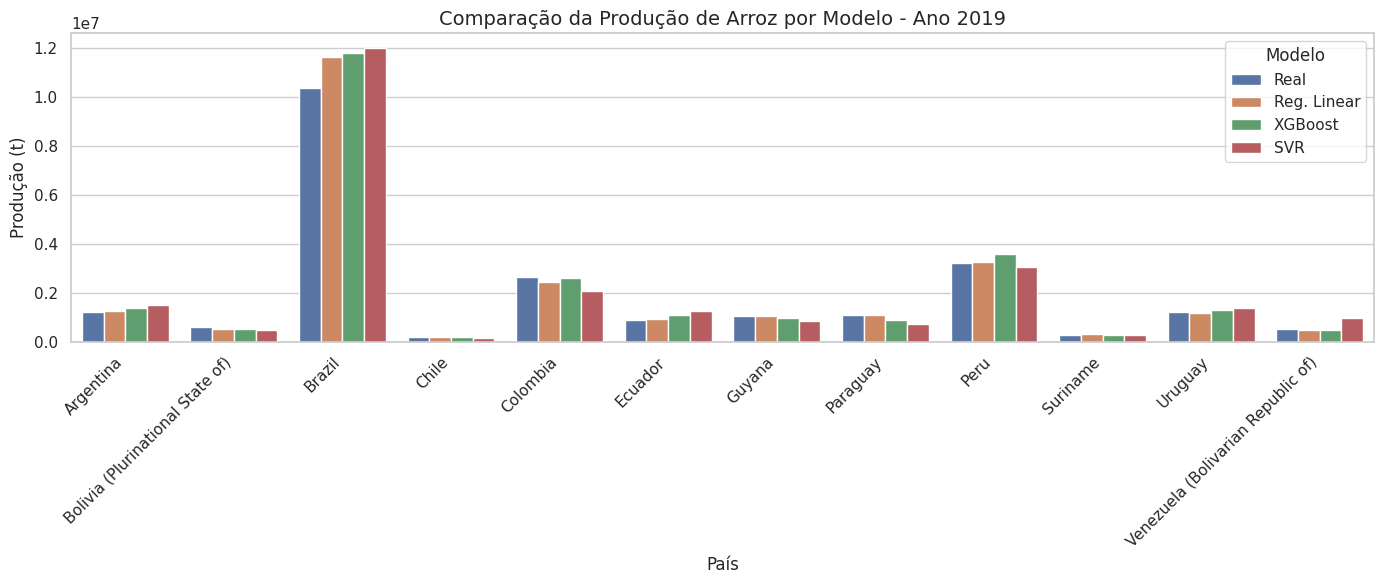

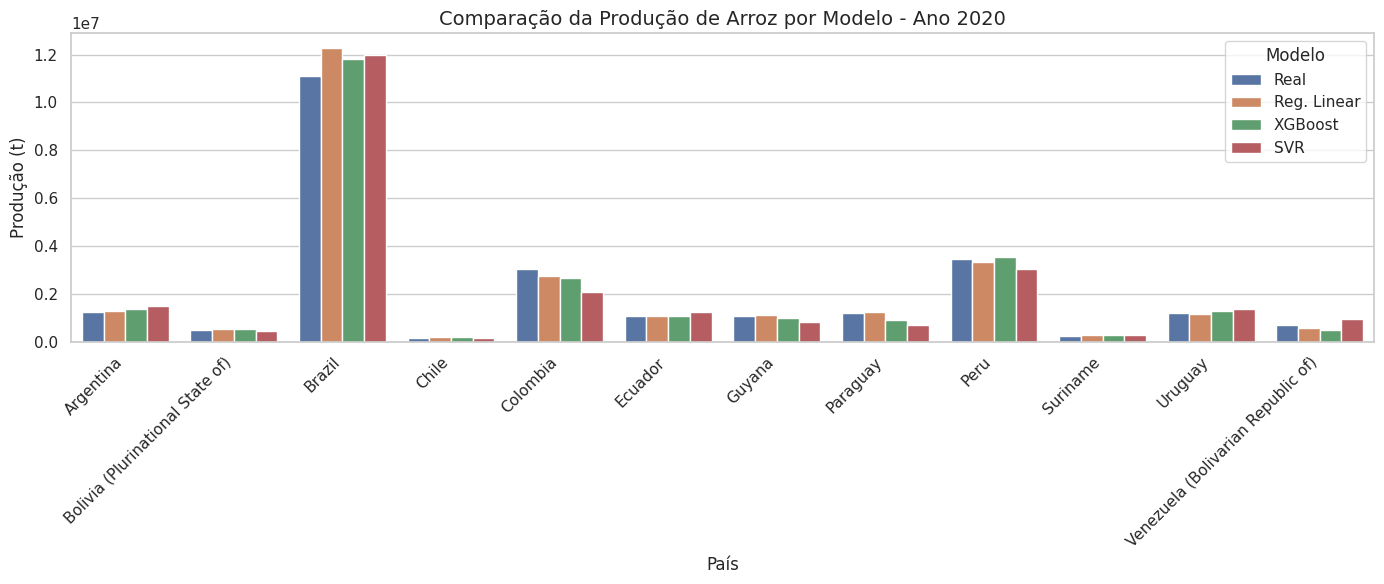

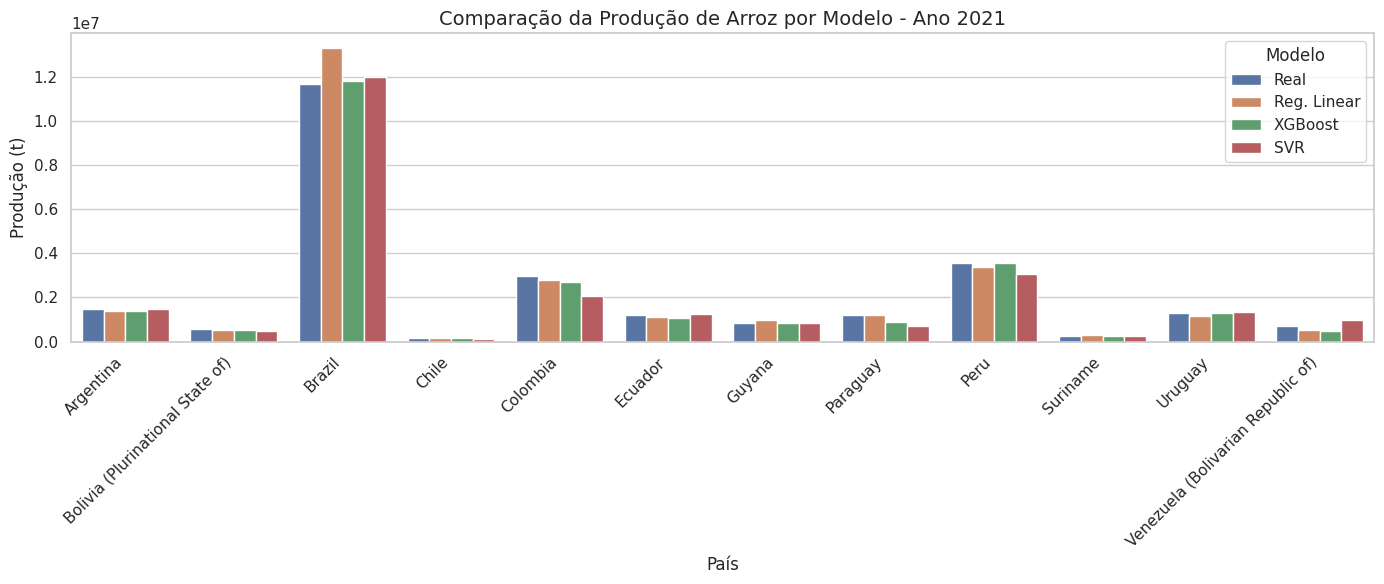

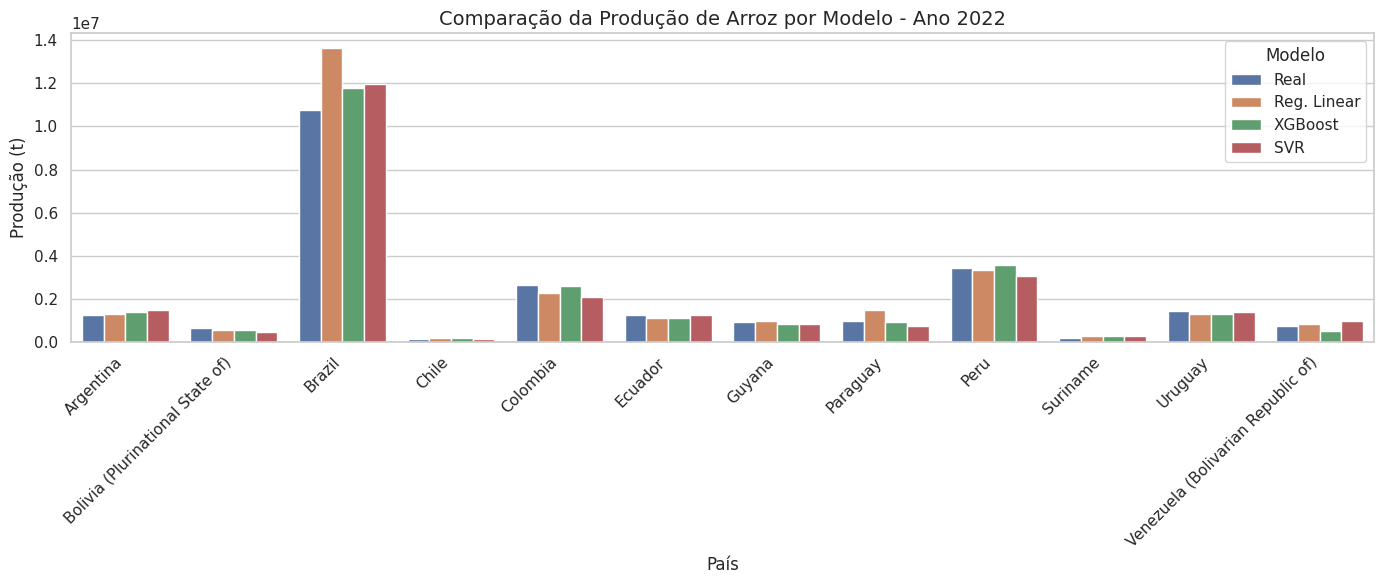

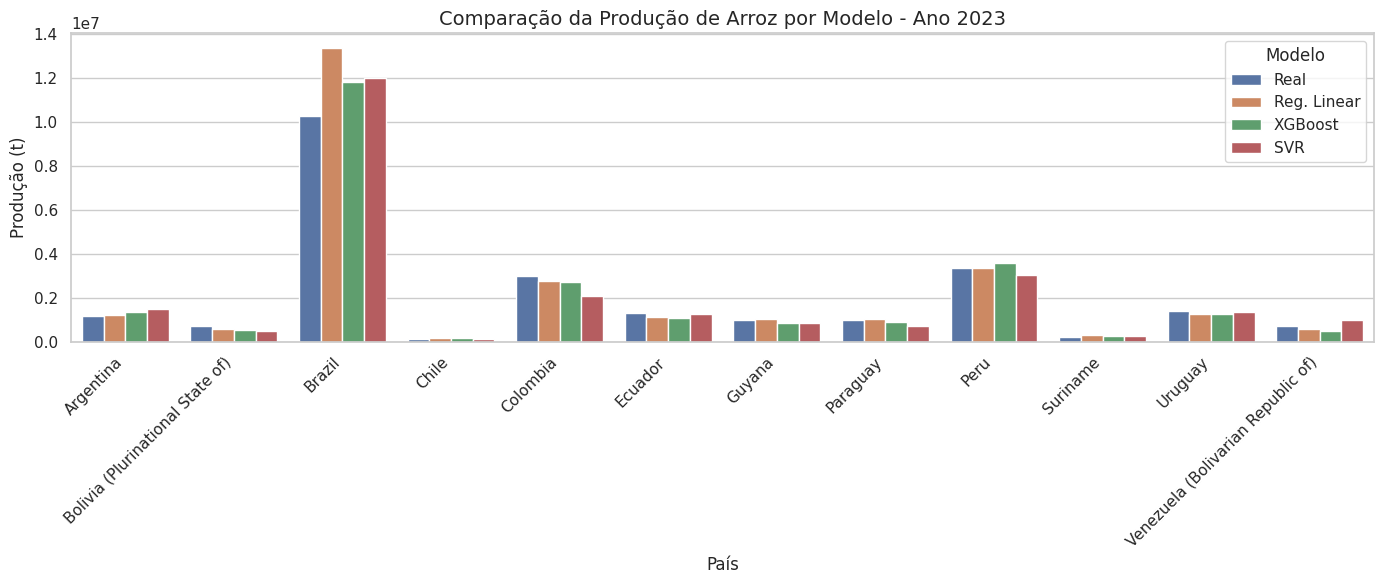

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Loop para um gráfico por ano
anos_previstos = sorted(df_resultado['Ano_Previsto'].unique())

for ano in anos_previstos:
    df_ano = df_resultado[df_resultado['Ano_Previsto'] == ano].copy()

    # Reformata para gráfico de barras agrupadas
    df_plot = pd.melt(df_ano,
                      id_vars='Area',
                      value_vars=['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR'],
                      var_name='Modelo',
                      value_name='Produção')

    # Renomear para legenda mais limpa
    df_plot['Modelo'] = df_plot['Modelo'].replace({
        'Production_Real': 'Real',
        'Prod_LR': 'Reg. Linear',
        'Prod_XGB': 'XGBoost',
        'Prod_SVR': 'SVR'
    })

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_plot, x='Area', y='Produção', hue='Modelo')
    plt.title(f'Comparação da Produção de Arroz por Modelo - Ano {ano}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Produção (t)')
    plt.xlabel('País')
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

In [ ]:
media_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR']
].mean().reset_index()


media_erro_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

print("Média da produção e previsões por ano:")
print(media_por_ano)

print("\nMédia dos erros percentuais por ano:")
print(media_erro_por_ano)

Média da produção e previsões por ano:
   Ano_Previsto  Production_Real      Prod_LR     Prod_XGB     Prod_SVR
0          2019     1,929,677.81 2,025,324.27 2,084,111.50 2,044,750.64
1          2020     2,077,073.25 2,145,784.94 2,088,750.62 2,044,759.50
2          2021     2,155,520.93 2,230,733.14 2,079,380.50 2,044,747.48
3          2022     2,018,670.75 2,260,703.10 2,069,591.38 2,044,721.67
4          2023     2,017,919.87 2,223,817.93 2,078,890.50 2,044,719.05

Média dos erros percentuais por ano:
   Ano_Previsto  Erro_%_Prod_LR  Erro_%_Prod_XGB  Erro_%_Prod_SVR
0          2019            5.82             9.83            25.95
1          2020            8.25            10.28            19.38
2          2021           10.57             9.06            13.32
3          2022           22.28            18.02            19.92
4          2023           16.99            19.30            21.24


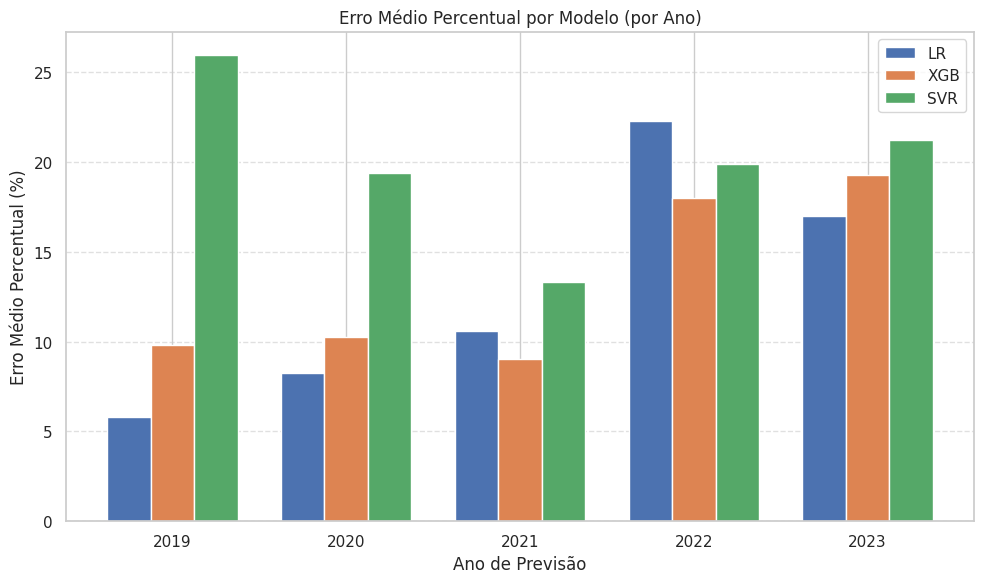

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotando as barras lado a lado por modelo
largura = 0.25
anos = media_erro_por_ano['Ano_Previsto']
x = range(len(anos))

plt.bar([p - largura for p in x], media_erro_por_ano['Erro_%_Prod_LR'], width=largura, label='LR')
plt.bar(x, media_erro_por_ano['Erro_%_Prod_XGB'], width=largura, label='XGB')
plt.bar([p + largura for p in x], media_erro_por_ano['Erro_%_Prod_SVR'], width=largura, label='SVR')

# Eixos e rótulos
plt.xticks(x, anos)
plt.ylabel('Erro Médio Percentual (%)')
plt.xlabel('Ano de Previsão')
plt.title('Erro Médio Percentual por Modelo (por Ano)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
# Calcular média dos erros percentuais por país
media_erro_por_pais = df_resultado.groupby('Area')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index().sort_values(by='Area')

# Exibir o resultado
print("Média dos erros percentuais por país:")
print(media_erro_por_pais.round(2))

Média dos erros percentuais por país:
                                  Area  Erro_%_Prod_LR  Erro_%_Prod_XGB  \
0                            Argentina            4.29            12.44   
1     Bolivia (Plurinational State of)           11.16            13.55   
2                               Brazil           18.71             9.20   
3                                Chile           31.14            21.22   
4                             Colombia            9.28             6.97   
5                              Ecuador            8.50            13.01   
6                               Guyana            5.16             9.51   
7                             Paraguay           13.08            16.41   
8                                 Peru            2.74             4.95   
9                             Suriname           23.82            19.90   
10                             Uruguay            7.95             6.06   
11  Venezuela (Bolivarian Republic of)           17.56        

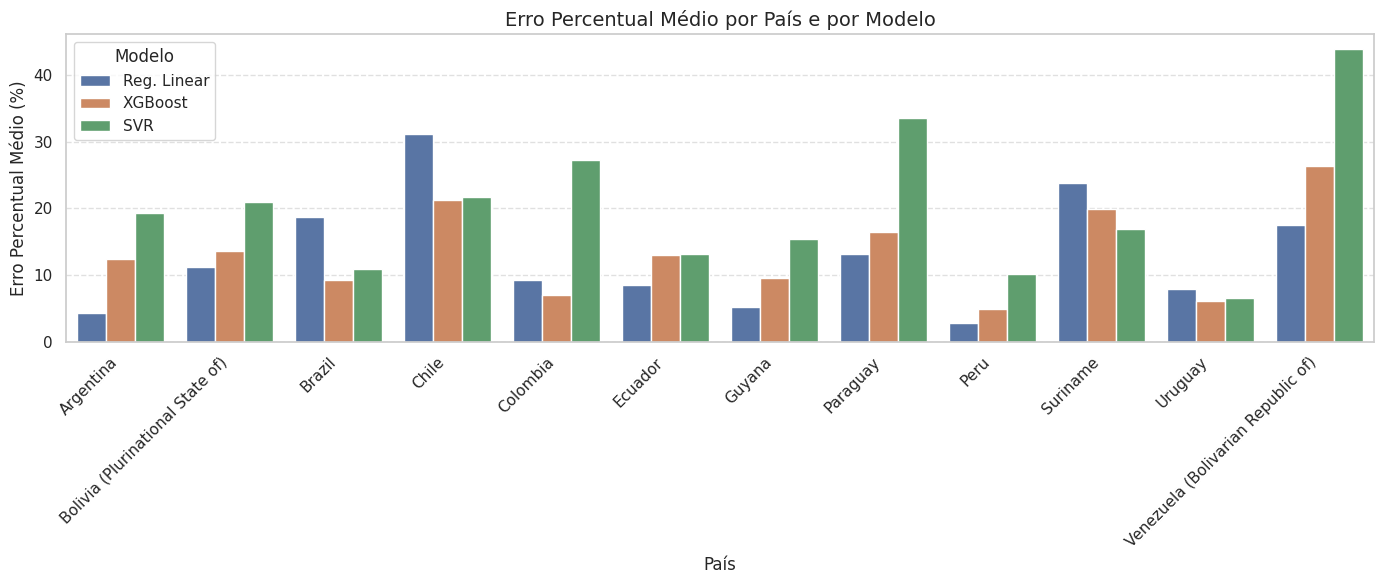

In [ ]:
# Calcular média dos erros percentuais por país
media_erro_por_pais = df_resultado.groupby('Area')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

# Visualização com seaborn e matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Reformata para gráfico de barras agrupadas
df_plot_pais = pd.melt(media_erro_por_pais,
                       id_vars='Area',
                       value_vars=['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR'],
                       var_name='Modelo',
                       value_name='Erro Percentual Médio')

# Renomear para legenda mais limpa
df_plot_pais['Modelo'] = df_plot_pais['Modelo'].replace({
    'Erro_%_Prod_LR': 'Reg. Linear',
    'Erro_%_Prod_XGB': 'XGBoost',
    'Erro_%_Prod_SVR': 'SVR'
})

# Gráfico
plt.figure(figsize=(14, 6))
sns.barplot(data=df_plot_pais, x='Area', y='Erro Percentual Médio', hue='Modelo')
plt.title('Erro Percentual Médio por País e por Modelo', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Erro Percentual Médio (%)')
plt.xlabel('País')
plt.legend(title='Modelo')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

                   MAPE Médio (%)  Desvio Padrão (%)
Linear Regression           34.87               6.26
XGBoost                     12.47               4.00
SVR                        137.23              22.65


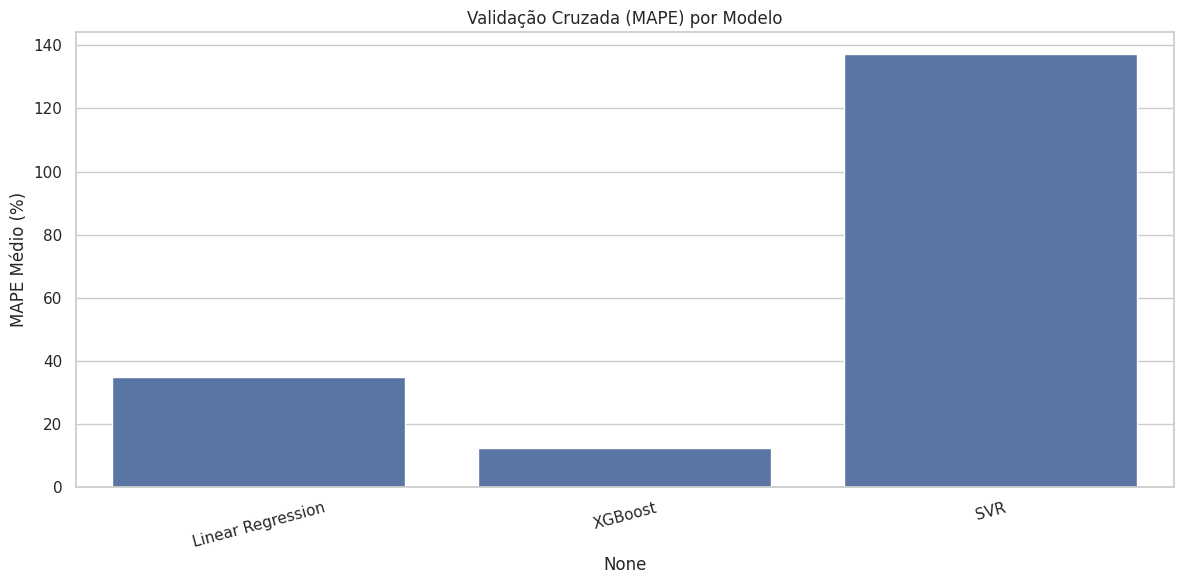

In [ ]:
#Entrega 2
#1)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
import pandas as pd

# Supondo que X e y já estejam definidos:
# X = df_treino[atributos]
# y = df_treino["Production"]

# Definindo as variáveis de entrada e saída
atributos = ['Area harvested (ha)', 'Yield (kg/ha)']  # ou os que fizerem sentido
X = df_treino[atributos]
y = df_treino['Production (t)']

# Normalização para SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Métrica MAPE customizada para usar no cross_val_score
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Dicionário de modelos
modelos = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

# Avaliação com cross-validation
resultados_cv = {}
for nome, modelo in modelos.items():
    if nome == "SVR":
        scores = cross_val_score(modelo, X_scaled, y, cv=5, scoring=mape_scorer)
    else:
        scores = cross_val_score(modelo, X, y, cv=5, scoring=mape_scorer)
    resultados_cv[nome] = {
        "MAPE Médio (%)": -scores.mean() * 100,
        "Desvio Padrão (%)": scores.std() * 100
    }

# Criar tabela
df_cv = pd.DataFrame(resultados_cv).T
df_cv = df_cv.round(2)

# Exibir
import matplotlib.pyplot as plt
import seaborn as sns

print(df_cv)

# Opcional: gráfico de barras
sns.barplot(x=df_cv.index, y="MAPE Médio (%)", data=df_cv)
plt.ylabel("MAPE Médio (%)")
plt.title("Validação Cruzada (MAPE) por Modelo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

#ERRO PERCENTUAL MÉDIO POR PAÍS
# Valores corrigidos
data = [
    ["Argentina", 4.29, 12.44, 19.22],
    ["Bolivia (Plurinational State of)", 11.16, 13.55, 20.99],
    ["Brazil", 18.71, 9.20, 10.90],
    ["Chile", 31.14, 21.22, 21.67],
    ["Colombia", 9.28, 6.97, 27.19],
    ["Ecuador", 8.50, 13.01, 13.19],
    ["Guyana", 5.16, 9.51, 15.35],
    ["Paraguay", 13.08, 16.41, 33.58],
    ["Peru", 2.74, 4.95, 10.11],
    ["Suriname", 23.82, 19.90, 16.92],
    ["Uruguay", 7.95, 6.06, 6.55],
    ["Venezuela (Bolivarian Republic of)", 17.56, 26.35, 43.90],
]

df_erros = pd.DataFrame(
    data,
    columns=["Area", "Erro_%_Prod_LR", "Erro_%_Prod_XGB", "Erro_%_Prod_SVR"]
)

# Padronização de nomes para o Plotly
nome_padrao = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Brazil": "Brazil",
    "Argentina": "Argentina",
    "Chile": "Chile",
    "Colombia": "Colombia",
    "Ecuador": "Ecuador",
    "Guyana": "Guyana",
    "Paraguay": "Paraguay",
    "Peru": "Peru",
    "Suriname": "Suriname",
    "Uruguay": "Uruguay",
}

df_plot = df_erros.copy()
df_plot["country_plotly"] = df_plot["Area"].map(nome_padrao).fillna(df_plot["Area"])

# Escolher o modelo a visualizar: "LR", "XGB" ou "SVR"
modelo_escolhido = "SVR"  # altere para "LR" ou "SVR" conforme necessário

col_map = {
    "LR": "Erro_%_Prod_LR",
    "XGB": "Erro_%_Prod_XGB",
    "SVR": "Erro_%_Prod_SVR"
}
col_erro = col_map[modelo_escolhido]

titulo = f"Erro Percentual Médio por País – {modelo_escolhido} (América do Sul)"

# Criar o mapa
fig_map = px.choropleth(
    df_plot,
    locations="country_plotly",
    locationmode="country names",
    color=col_erro,
    color_continuous_scale="Reds",
    title=titulo,
)
fig_map.update_geos(scope="south america", showcountries=True, showsubunits=True)
fig_map.update_layout(coloraxis_colorbar_title="Erro (%)", margin=dict(l=0, r=0, t=60, b=0))
fig_map.show()
